# Train, debug & profile Machine Learning Models
## 1. Training with Hyperparameter Tuning Jobs

In this notebook, we train the same **SKLearn** `RandomForestClassifier` to predict bank customers' churn, with the additional step of hyperparameters tuning. 
Hyperparameter tuning jobs launch parralelt Training Jobs and select the best generated model according to the objective metric set by the user.

Several options for tuning strategies are available, such as `RandomSearch` or `Bayesian` optimization.

![hpt.png](https://d-mqesdqdqrfmi.studio.eu-west-3.sagemaker.aws/jupyter/default/files/AWS-machine-learning-orchestration/Model%20Training%20%26%20Debugging/hpt.png?_xsrf=2%7C40a831f4%7Cf82e4b60f64d762f763ec120b9025b39%7C1716535824)

In [2]:
import os
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### 1.1 Provide environment, S3 data configuration and metric definitions

Similarly as for Training jobs, theses configurations are required to run the hyperparameter tuner. The objective metric is also configured to be the validation accuracy, and will serve as the function to maximize during the tuning job.

In [60]:
####### Training & Validation Datasets #######
train_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2024-03-06-21-05-51-569/output/bank-churn-train/'.format(bucket)
validation_data_s3_uri = 's3://{}/sagemaker-scikit-learn-2024-03-06-21-05-51-569/output/bank-churn-validation/'.format(bucket)



####### Job parameters #######
FRAMEWORK_VERSION = '1.0-1'
instance_type = 'ml.m5.large'
instance_count = 1



####### Metric definitions #######
metric_definitions = [
    {'Name': 'validation:precision', 'Regex': 'val_precision: ([0-9.]+)'},
    {'Name': 'validation:recall', 'Regex': 'val_recall: ([0-9.]+)'},
    {'Name': 'validation:f1Score', 'Regex': 'val_f1score: ([0-9.]+)'},
    {'Name': 'validation:ROCAUC', 'Regex': 'val_roc_auc: ([0-9.]+)'},
    {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9.]+)'}
]

objective = 'validation:accuracy'


### 1.2 Configure Hyperparameters

Some of the hyperparameters are static, and some are configured as the **Search Space** available for the Hyperparameter Tuning Job.

In [61]:
from sagemaker.parameter import CategoricalParameter, ContinuousParameter, IntegerParameter


####### Static hyperparameters #######
static_hyperparameters = {
    'random_state': 2024
}

####### Hyperparameter ranges #######
hyperparameter_ranges = {
    'n_estimators': IntegerParameter(min_value=10, 
                                     max_value=200, 
                                     scaling_type='Logarithmic'),
    
    'max_depth': IntegerParameter(min_value=3, 
                                  max_value=10, 
                                  scaling_type='Linear'),
    
    'criterion': CategoricalParameter(values=['gini', 'entropy'])
}


### 1.3 Instanciate the `SKLearn` Estimator

Static hyperparameters are configured at this level.

In [84]:
from sagemaker.sklearn.estimator import SKLearn


estimator = SKLearn(
        entry_point='src/training.py',
        framework_version=FRAMEWORK_VERSION,
        instance_count=instance_count,
        instance_type=instance_type,
        role=role,
        hyperparameters=static_hyperparameters,
        metric_definitions= metric_definitions
)


### 1.4 Instanciate the Hyperparameter Tuner

The search space for hyperparameters are configured at this level, along with the `strategy` and the `objective_type`.

The number of training jobs and parallel training jobs can also be limited, this is done through setting
- `max_jobs = 12`
- `max_parallel jobs = 1`

In [85]:
from sagemaker.tuner import HyperparameterTuner


tuner = HyperparameterTuner(
        estimator=estimator,
        objective_metric_name=objective,
        hyperparameter_ranges=hyperparameter_ranges,
        metric_definitions=metric_definitions,
        strategy='Bayesian',
        objective_type='Maximize',
        max_jobs=12,                # maximum number of jobs to run
        max_parallel_jobs=1,        # maximum number of jobs to run in parallel
        early_stopping_type='Auto'
)


### 1.5 Configure the data channels

The training inputs will be copied to the local training image for each Training Job.

In [86]:
from sagemaker.inputs import TrainingInput

data_channels = {
    'train': TrainingInput(s3_data=train_data_s3_uri),
    'validation': TrainingInput(s3_data=validation_data_s3_uri)
}


### 1.6 Fit the Hyperparameter Tuner
The above `data channels` are used as the inputs for this job.

In [87]:
tuner.fit(
    inputs=data_channels,
    include_cls_metadata=False,
    wait=False,
)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


## 2. Review Tuning Job Analytics
Once the tuning job is completed, information can be retrieved on the status of the training jobs. More general infomation like the Tuning Job Name can also be displayed.

In [156]:
tuning_job_name = tuner.describe().get('HyperParameterTuningJobName')


In [159]:
from IPython.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/hyper-tuning-jobs/{}">Hyper-Parameter Tuning Job</a></b>'.format(region, tuning_job_name)))

In [155]:
# tuner.describe()

pprint(tuner.describe().get('HyperParameterTuningJobName'))
pprint(tuner.describe().get('HyperParameterTuningJobConfig'))
pprint(tuner.describe().get('TrainingJobStatusCounters'))
pprint(tuner.describe().get('ObjectiveStatusCounters'))


'sagemaker-scikit-lea-240604-1642'
{'HyperParameterTuningJobObjective': {'MetricName': 'validation:accuracy',
                                      'Type': 'Maximize'},
 'ParameterRanges': {'CategoricalParameterRanges': [{'Name': 'criterion',
                                                     'Values': ['"gini"',
                                                                '"entropy"']}],
                     'ContinuousParameterRanges': [],
                     'IntegerParameterRanges': [{'MaxValue': '200',
                                                 'MinValue': '10',
                                                 'Name': 'n_estimators',
                                                 'ScalingType': 'Logarithmic'},
                                                {'MaxValue': '10',
                                                 'MinValue': '3',
                                                 'Name': 'max_depth',
                                                 'ScalingT

### 2.1 Display the respective

In [121]:
tuner.analytics().dataframe().sort_values(by='FinalObjectiveValue', ascending=False)


,criterion,max_depth,n_estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""gini""",7.0,200.0,sagemaker-scikit-lea-240604-1642-012-e4daeadc,Completed,1.000000,2024-06-04 16:56:30+00:00,2024-06-04 16:57:19+00:00,49.0
1,"""gini""",10.0,29.0,sagemaker-scikit-lea-240604-1642-011-7ef0280a,Completed,1.000000,2024-06-04 16:55:12+00:00,2024-06-04 16:55:55+00:00,43.0
3,"""entropy""",6.0,136.0,sagemaker-scikit-lea-240604-1642-009-eabbca5b,Completed,1.000000,2024-06-04 16:53:03+00:00,2024-06-04 16:53:46+00:00,43.0
5,"""gini""",6.0,15.0,sagemaker-scikit-lea-240604-1642-007-1e477b31,Completed,1.000000,2024-06-04 16:50:48+00:00,2024-06-04 16:51:31+00:00,43.0
10,"""entropy""",9.0,101.0,sagemaker-scikit-lea-240604-1642-002-59cbda6b,Completed,1.000000,2024-06-04 16:45:46+00:00,2024-06-04 16:46:29+00:00,43.0
7,"""gini""",9.0,20.0,sagemaker-scikit-lea-240604-1642-005-f8db7f6b,Completed,1.000000,2024-06-04 16:48:50+00:00,2024-06-04 16:49:39+00:00,49.0
9,"""gini""",8.0,87.0,sagemaker-scikit-lea-240604-1642-003-ee62c3e0,Completed,1.000000,2024-06-04 16:46:49+00:00,2024-06-04 16:47:38+00:00,49.0
11,"""gini""",7.0,21.0,sagemaker-scikit-lea-240604-1642-001-9735a17f,Completed,0.998765,2024-06-04 16:43:37+00:00,2024-06-04 16:45:36+00:00,119.0
6,"""entropy""",10.0,12.0,sagemaker-scikit-lea-240604-1642-006-d77c42a6,Stopped,0.950617,2024-06-04 16:49:58+00:00,2024-06-04 16:50:36+00:00,38.0
2,"""entropy""",8.0,16.0,sagemaker-scikit-lea-240604-1642-010-63f91fef,Completed,0.919753,2024-06-04 16:54:12+00:00,2024-06-04 16:54:56+00:00,44.0


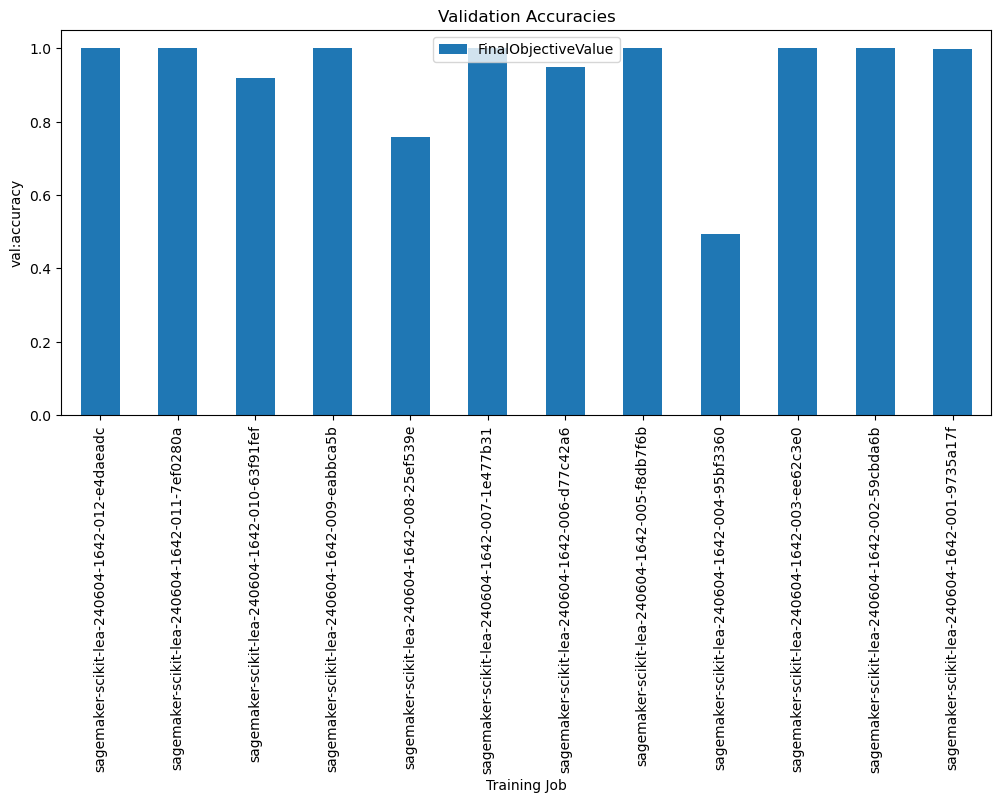

In [140]:
import matplotlib.pyplot as plt


tuner.analytics().dataframe().plot.bar(x='TrainingJobName', 
                                       y='FinalObjectiveValue',
                                       title='Validation Accuracies',
                                       xlabel='Training Job',
                                      ylabel='val:accuracy',
                                      figsize=(12,5));


### 2.2 Display best Training Job

In [161]:
best_training_job = tuner.describe().get('BestTrainingJob')
best_training_job_name = best_training_job.get('TrainingJobName')

pprint(best_training_job)

{'CreationTime': datetime.datetime(2024, 6, 4, 16, 45, 42, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 1.0},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 6, 4, 16, 46, 29, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-3:668303144976:training-job/sagemaker-scikit-lea-240604-1642-002-59cbda6b',
 'TrainingJobName': 'sagemaker-scikit-lea-240604-1642-002-59cbda6b',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 6, 4, 16, 45, 46, tzinfo=tzlocal()),
 'TunedHyperParameters': {'criterion': '"entropy"',
                          'max_depth': '9',
                          'n_estimators': '101'}}


In [162]:
display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Best Training Job</a></b>'.format(region, best_training_job_name)))
